# Descripción del proyecto.

Trabajas en la compañía de extracción de petróleo OilyGiant. Tu tarea es encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo.

Para completar esta tarea, tendrás que realizar los siguientes pasos:

- Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
- Crear un modelo para predecir el volumen de reservas en pozos nuevos.
- Elegir los pozos petrolíferos que tienen los valores estimados más altos.
- Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.

Se creará un modelo que ayude a elegir la región con el mayor margen de beneficio. Analiza los beneficios y riesgos potenciales utilizando la técnica *bootstrapping*.

# Parte 1. Descargar y prerar los datos.

## 1.1 Librerías.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap, norm


## 2.2 Carga de datos.

In [2]:
geo_data_0 = pd.read_csv("geo_data_0.csv")
geo_data_1 = pd.read_csv("geo_data_1.csv")
geo_data_2 = pd.read_csv("geo_data_2.csv")

In [3]:
print(geo_data_0.head(),"\n")
print(geo_data_1.head(),"\n")
print(geo_data_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [4]:
print(geo_data_0.info(),"\n")
print(geo_data_1.info(),"\n")
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

In [5]:
print(geo_data_0.describe(include='all'),"\n")
print(geo_data_1.describe(include='all'),"\n")
print(geo_data_2.describe(include='all'))

            id             f0             f1             f2        product
count   100000  100000.000000  100000.000000  100000.000000  100000.000000
unique   99990            NaN            NaN            NaN            NaN
top      fiKDv            NaN            NaN            NaN            NaN
freq         2            NaN            NaN            NaN            NaN
mean       NaN       0.500419       0.250143       2.502647      92.500000
std        NaN       0.871832       0.504433       3.248248      44.288691
min        NaN      -1.408605      -0.848218     -12.088328       0.000000
25%        NaN      -0.072580      -0.200881       0.287748      56.497507
50%        NaN       0.502360       0.250252       2.515969      91.849972
75%        NaN       1.073581       0.700646       4.715088     128.564089
max        NaN       2.362331       1.343769      16.003790     185.364347 

            id             f0             f1             f2        product
count   100000  100000.

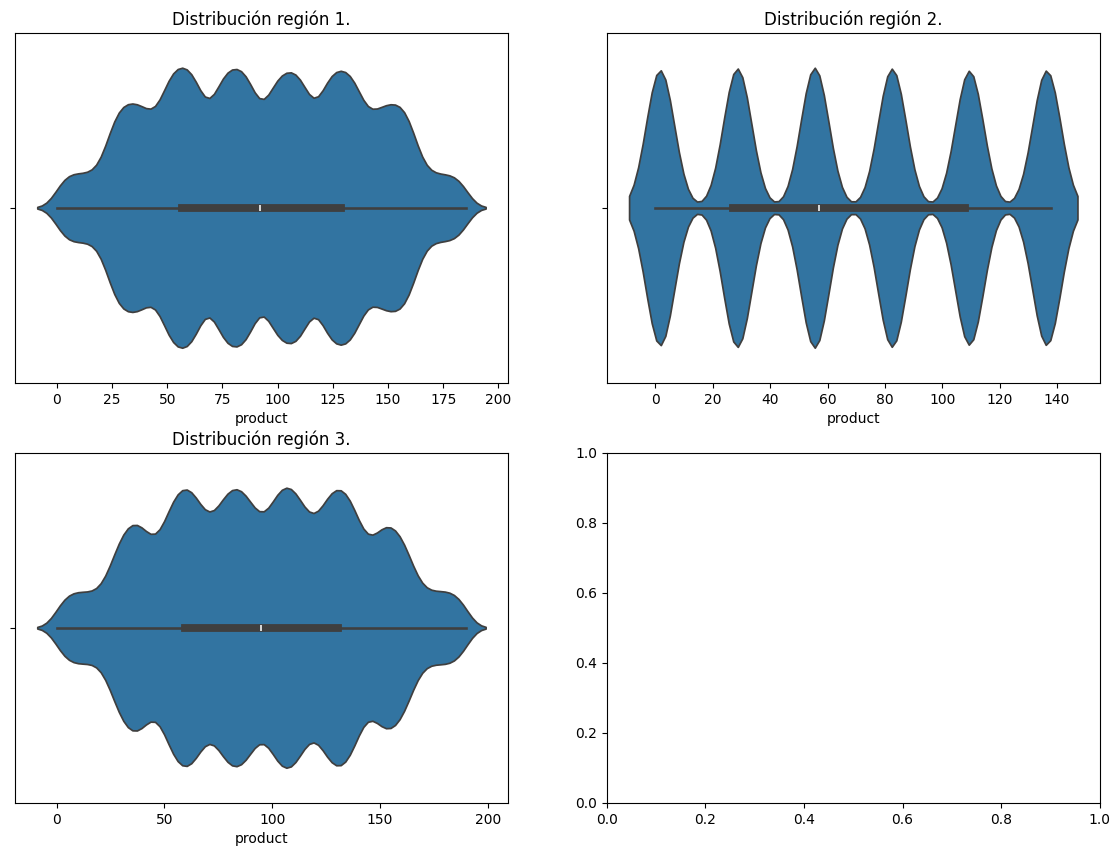

In [6]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(10)
sns.violinplot(ax=ax1,x=geo_data_0['product'])
ax1.set_title('Distribución región 1.')
sns.violinplot(ax=ax2,x=geo_data_1['product'])
ax2.set_title('Distribución región 2.')
sns.violinplot(ax=ax3,x=geo_data_2['product'])
ax3.set_title('Distribución región 3.')
plt.show()

 Los datos se cargaron se forma existosa. Los 3 conjunto de datos no tiene ningún valor nulo y el tipo de objeto corresponde correctamente a los datos. En la descripción estadítica se obtuvo que hay 99 996 valores únicos, en cada región se repiten 2 pozos (`id`). La región 1 y 3 tiene una distribucipon de lso datos `product` de manera similar, mientras que la región 2 tiene una distribución sesgada hacia la derecha.

### 2.2.1 Revisar los datos duplicados.

El dato duplicado en la región 2 es  `fiKDv`.

In [7]:
geo_data_0.query("id == 'fiKDv'")

,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


El dato duplicado en la región 2 es `wt4Uk`.

In [8]:
geo_data_1.query("id == 'wt4Uk'")

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Los datos duplicados en la región 3 son `VF7Jo`.

In [9]:
geo_data_2.query("id == 'VF7Jo'")

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


A pesar de que tinen el mimso `id` en los 3 conjunto de datos, tienen diferentes registros.

# Parte 2. Entrenamiento y prueba del modelo

En este siguiente paso se entranará y se probará el modelopara cada región en el conjunto de datos `geo_data_0`. Se dividirá en el conjunto de datos en conjunto de entranmeinto y prueba en el proporción de 75:25. El modelo a entrenar será una regresión lineal y se revisará el calidad del mismo. Se colocarán los pasos previos en una función para el conjunto de datos `geo_data_1` y `geo_data_2`.

## 2.1. Dividir el conjunto de datos.

No se toma en cuenta la columna `id` para entranr el modelo debido a la acción que va tomar el modelo de aprenderse la caraterísticas de memoria.

In [10]:
X = geo_data_0[['f0','f1','f2']]
y = geo_data_0['product']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


## 2.2. Escalamiento de datos.

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.fit_transform(X_test),columns=X_test.columns)

In [12]:
print(X_train_scaled)
print(X_test_scaled)

             f0        f1        f2
0      1.274786 -0.799739 -0.396677
1     -1.600689  0.234678 -2.169283
2     -0.323791  1.436297  1.495425
3      0.439038  0.830679  0.185881
4     -1.652805  0.761012  0.111734
...         ...       ...       ...
74995  1.291452 -0.712129  0.135573
74996  1.355542 -0.882161 -1.134411
74997  0.549229 -1.591632  0.119090
74998  0.175176 -1.459344  1.429524
74999  1.029803 -1.420625 -0.149459

[75000 rows x 3 columns]
             f0        f1        f2
0      0.112101 -1.589321 -0.110233
1      0.272610 -1.402931 -1.179141
2      1.057993 -1.544522  0.382073
3      1.238912 -0.959586  0.100531
4      0.479323 -0.441815  0.036875
...         ...       ...       ...
24995  0.290564 -1.499725  0.040633
24996 -0.647567  0.530756 -0.543723
24997  0.105767 -1.328161 -0.925665
24998 -0.348606  0.406562 -0.302406
24999 -0.859695  1.509676  0.677737

[25000 rows x 3 columns]


## 2.3 Entrenamiento y calidad del modelo.

### 2.3.1. Región 1.

In [13]:
model = LinearRegression()
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test,y_pred)
rmse = mse**0.5

In [15]:
print("Volumen medio de reservas predicho:", y_test.mean())
print('\nRMSE del modelo en el conjunto de prueba:', rmse)

Volumen medio de reservas predicho: 92.32595637084387

RMSE del modelo en el conjunto de prueba: 81.11662851393159


La RECM nos indica que en promedio nuetras predicciones erran por ~ 81 117 barriles. Parece mucho pero es aceptable para un modelo que siempre responde con el valor debajo de la media, dado que la región con más reservas de barriles llegan a más de 185 mil.

### 2.3.2 Preparar la función.

In [16]:
def rmse_L_Regression(data):
    features = data[['f0','f1','f2']]
    target = data['product']
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.25, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train),columns=features.columns)
    X_test_scaled = pd.DataFrame(data=scaler.fit_transform(X_test),columns=features.columns)
    model = LinearRegression()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test,y_pred) ** 0.5
    print("Volumen medio de reservas predicho:", y_test.mean())
    print('\nRMSE del modelo en el conjunto de prueba:', rmse)

### 2.3.3 Región 2.

In [17]:
rmse_L_Regression(geo_data_1)

Volumen medio de reservas predicho: 68.72538074722745

RMSE del modelo en el conjunto de prueba: 0.8999970499802324


El RMSE indica en nuetras predicciones erran unos ~900 barriles. Bastante bien para este conjunto de datos.

### 2.3.4 Región 3

In [18]:
rmse_L_Regression(geo_data_2)

Volumen medio de reservas predicho: 95.15099907171961

RMSE del modelo en el conjunto de prueba: 40.1447439796432


El RMSE indica que las predicciones de la región 3 tienen en error medio de 40 mil barriles.

# Parte 3. Preparar cálculo de ganancias.

El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares. Dicho esto, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Se comparó esta cantidad con la cantidad media de reservas en cada región.

In [19]:
presupuesto = 100_000_000
cantidad_pozos = 200
ingresos_barril = 4_500
lucro_minimo_unidades = 111.1

### 3.1 Cantidad media de barriles y ganancias en cada región.

In [20]:
barril_r1_mean =  geo_data_0['product'].mean()
ingresos_r1 = barril_r1_mean * ingresos_barril
print("Región 1:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r1_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r1:.2f}")

Región 1:

Unidades de barriles producidos en promedio: 92.50

Ganancias en USD: 416250.00


In [21]:
barril_r2_mean =  geo_data_1['product'].mean()
ingresos_r2 = barril_r2_mean * ingresos_barril
print("Región 2:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r2_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r2:.2f}")

Región 2:

Unidades de barriles producidos en promedio: 68.83

Ganancias en USD: 309712.50


In [22]:
barril_r3_mean =  geo_data_2['product'].mean()
ingresos_r3 = barril_r3_mean * ingresos_barril
print("Región 3:\n")
print(f"Unidades de barriles producidos en promedio: {barril_r3_mean:.2f}\n")
print(f"Ganancias en USD: {ingresos_r3:.2f}")

Región 3:

Unidades de barriles producidos en promedio: 95.00

Ganancias en USD: 427500.00


Ninguna de las regiones llega a la unidades de 111.1 barriles o 500 000 dólares.

# Parte 4. Escribe una función para calcular la ganancia de un conjunto de pozos de petróleo seleccionados y modela las predicciones

### 4.1 Elige los 200 pozos con los valores de predicción más altos de cada una de las 3 regiones.

In [23]:
def valores_mas_altos(data):
    X = data[['f0','f1','f2']]
    y = data['product']
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    prediction = pd.Series(model.predict(X_test))
    X_test = X_test.reset_index(drop=True)
    
    prediction.name = 'prediction'
    
    region = X_test.join(prediction)
    indice = region['prediction'].nlargest(200).index
    region_200 = region.iloc[indice,:]
    return region_200
    

In [24]:
print("Región 1:\n")
print(f"Unidades de barriles producidos en promedio: {valores_mas_altos(geo_data_0)['prediction'].mean():.2f}\n")
print(f"Ganancias en USD: {valores_mas_altos(geo_data_0)['prediction'].mean()*ingresos_barril:.2f}")

Región 1:

Unidades de barriles producidos en promedio: 154.41

Ganancias en USD: 694832.92


In [25]:
print("Región 2:\n")
print(f"Unidades de barriles producidos en promedio: {valores_mas_altos(geo_data_1)['prediction'].mean():.2f}\n")
print(f"Ganancias en USD: {valores_mas_altos(geo_data_1)['prediction'].mean()*ingresos_barril:.2f}")

Región 2:

Unidades de barriles producidos en promedio: 138.74

Ganancias en USD: 624346.91


In [26]:
print("Región 3:\n")
print(f"Unidades de barriles producidos en promedio: {valores_mas_altos(geo_data_2)['prediction'].mean():.2f}\n")
print(f"Ganancias en USD: {valores_mas_altos(geo_data_2)['prediction'].mean()*ingresos_barril:.2f}")

Región 3:

Unidades de barriles producidos en promedio: 148.64

Ganancias en USD: 668899.08


Calculando la predicción de las 200 pozos de las 3 regiones, se propone la región 1 para el desarrollo de pozos petrolíferos ya que la ganancia sería de 694 832.92 USD. Computing the prediction of the top 200 wells with the highets barrels production in each region, we selected the region 1 for the development of oil wells as the profit would be up to 694 832.92 dollars.

# Parte 5. Riesgos y ganancias de cada región.

## 5.1. Utilizando las predicciones que almacenaste en el paso 4.1, emplea la técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.

In [27]:
main_wells = valores_mas_altos(geo_data_0).reset_index(drop=True)

In [28]:
def distribution(data,title=''):    
    data = (data['prediction']*ingresos_barril,)

    fig, ax = plt.subplots()

    ax.hist(bootstrap(data,statistic=np.mean,n_resamples=1000,random_state=12345).bootstrap_distribution,bins=25,)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('USD.')

    fig.set_figwidth(8)
    fig.set_figheight(4)

    plt.show()

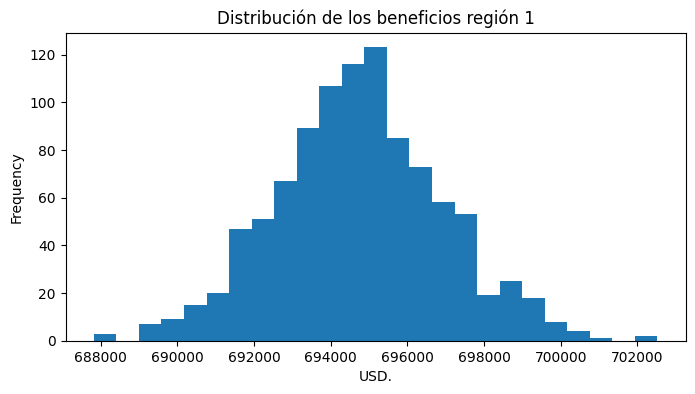

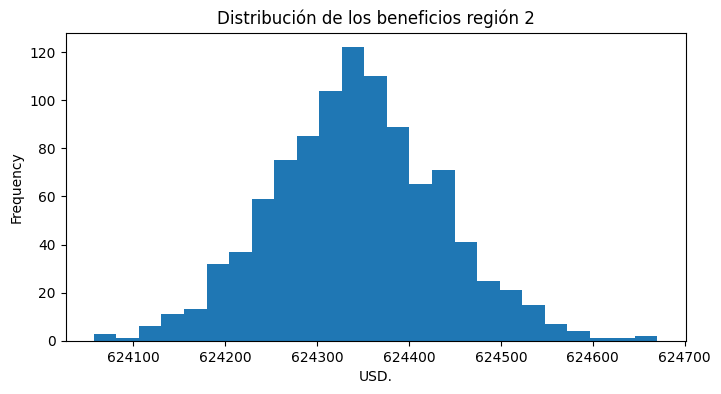

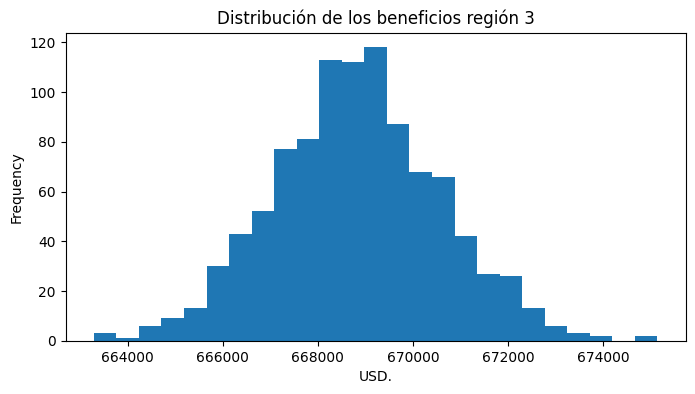

In [54]:
distribution(valores_mas_altos(geo_data_0).reset_index(drop=True),'Distribución de los beneficios región 1')

distribution(valores_mas_altos(geo_data_1).reset_index(drop=True),'Distribución de los beneficios región 2')

distribution(valores_mas_altos(geo_data_2).reset_index(drop=True),'Distribución de los beneficios región 3')

## 5.2 Encuentra el beneficio promedio, el intervalo de confianza del 95% y el riesgo de pérdidas. La pérdida es una ganancia negativa, calcúlala como una probabilidad y luego exprésala como un porcentaje.

In [35]:
def intervalo_confianza(data):
    state =  np.random.RandomState(12345)

    values = []

    for i in range(1000):
        beneficios = valores_mas_altos(data).reset_index(drop=True)['prediction']*ingresos_barril
        subsample = beneficios.sample(frac=1, replace=True, random_state = state)
        values.append(subsample.mean())
        
    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    return lower, upper

In [36]:
print(f"Intervalor de confianza en la región 1: {intervalo_confianza(geo_data_0)}\n")
print(f"Intervalor de confianza en la región 2: {intervalo_confianza(geo_data_1)}\n")
print(f"Intervalor de confianza en la región 3: {intervalo_confianza(geo_data_2)}")

Intervalor de confianza en la región 1: (690402.840024848, 699144.5616102458)

Intervalor de confianza en la región 2: (624161.5044639399, 624529.989130276)

Intervalor de confianza en la región 3: (665455.3524220987, 672313.7764078513)


In [45]:
def ROI(benefecio_neto,inversion):
    return str((benefecio_neto - inversion)/inversion * 100) + ' %'

In [53]:
beneficio_neto_region_1 = valores_mas_altos(geo_data_0)['prediction'].mean()
beneficio_neto_region_2 = valores_mas_altos(geo_data_1)['prediction'].mean()
beneficio_neto_region_3 = valores_mas_altos(geo_data_2)['prediction'].mean()

print(f"Probabilidad de pérdidas en la región 1: {ROI(beneficio_neto_region_1,presupuesto)}")
print(f"Probabilidad de pérdidas en la región 2: {ROI(beneficio_neto_region_2,presupuesto)}")
print(f"Porbalilidad de pérdidas en la región 3: {ROI(beneficio_neto_region_3,presupuesto)}")

Probabilidad de pérdidas en la región 1: -99.99984559268356 %
Probabilidad de pérdidas en la región 2: -99.99986125624318 %
Porbalilidad de pérdidas en la región 3: -99.99985135576097 %


## 5.3 Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección. ¿Coincide tu elección con la elección anterior en el punto 4.3?

Se propone la región 1 para el desarrollo. En el paso **4.1** obtuvimos que la región con los mejores 200 pozos con mejor ganancia es la región 1. En el paso **5.1**, su distribución obtuvimos, haciendo bootstraping, que los beneficios en promedio están entre los 694 mil y 696 mil USD. Y sus pérdidas son de **-99.99 %** como la región 2 y 3.